<a href="https://colab.research.google.com/github/KirkDCO/HandsOnML_Exercises/blob/main/Ch17_Q10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!cp -r drive/MyDrive/Colab\ Notebooks/HandsOnML/Ch17_Q10/flowers sample_data/.

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8793180719380736612
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1618480995722571
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [13]:
# imports and globals

import tensorflow as tf
from tensorflow import keras
K = keras.backend

import numpy as np
import matplotlib.pyplot as plt
import random

BATCH_SIZE = 32 

IMG_WIDTH  = 96
IMG_HEIGHT = 96

ENCODING_SIZE = 1024

In [3]:
# create a data generator based on the stored flower files

################################################################################
#  Describe where to find the flowers data set, how it is
#  accessed, etc.  
################################################################################ 

training_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "sample_data/flowers",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None, 
  validation_split = 0.2,
  subset = 'training'
)

validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "sample_data/flowers",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None, 
  validation_split = 0.2,
  subset = 'validation'
)
# provide X -> X for the autoencoder
def replicate_inputs_to_outputs(images):
  return images/255, images/255

training_generator = training_generator.prefetch(128)
validation_generator = validation_generator.prefetch(128)

X_train = training_generator.map(replicate_inputs_to_outputs)
X_valid = validation_generator.map(replicate_inputs_to_outputs)


Found 12847 files belonging to 1 classes.
Using 10278 files for training.
Found 12847 files belonging to 1 classes.
Using 2569 files for validation.


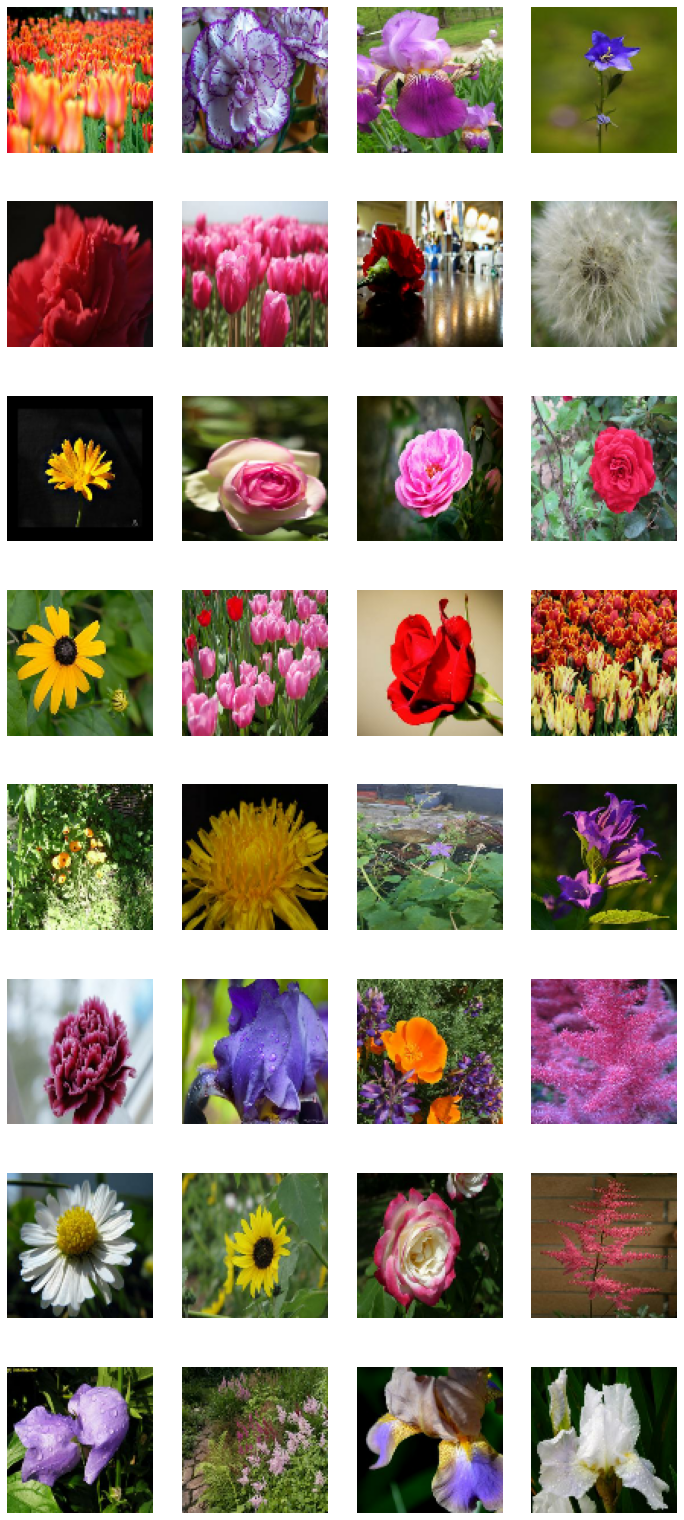

In [5]:
# visualize a few random flowers
# *** need to add labels
plt.figure(figsize=(12, 28))
for images in training_generator.take(1):
  for i in range(len(images)):
      ax = plt.subplot(8, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      # plt.title(class_names[labels[i]])
      plt.axis("off")

In [ ]:
# build a standard AE 
# the AE needs to be fairly complex in order to capture 13 different flower types
# follow VGG type of CNNs to balance complexity and speed

encoder = keras.models.Sequential([
            keras.layers.Conv2D(32, input_shape = [96, 96, 3], kernel_size = 3, 
                                padding = 'same', activation = 'relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D(64, kernel_size = 3,
                                padding = 'same', activation = 'relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D(128, kernel_size = 3,
                                padding = 'same', activation = 'relu'),
            keras.layers.Flatten(),
            keras.layers.Dense(ENCODING_SIZE)
])

encoder.summary()

decoder = keras.models.Sequential([
            keras.layers.Dense(128 * 24 * 24 , activation = "relu", input_shape = [ENCODING_SIZE]),
            keras.layers.Reshape([24, 24, 128]),
            keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,
                                         padding = "same", activation = "relu"),
            keras.layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2,
                                         padding = "same", activation = "relu"),
            keras.layers.Conv2DTranspose(filters = 3, kernel_size = 3, 
                                         padding = 'same', activation = 'sigmoid')
])

decoder.summary()

ae = keras.models.Sequential([encoder, decoder])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 73728)             0

In [ ]:
# train
# add learning rate scheduling 
def exponential_decay_fn(epoch):
  return 0.001 * 0.1 ** (epoch / 10)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# add early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

# clear the session for a clean run
keras.backend.clear_session()
tf.random.set_seed(42)

# compile and run
ae.compile(loss = "mean_squared_error", optimizer = keras.optimizers.Nadam())
history = ae.fit(X_train, validation_data = X_valid,  epochs = 25, \
                 callbacks = [lr_scheduler, early_stopping_cb])

Epoch 1/25
322/322 [==============================] - 31s 90ms/step - loss: 0.0142 - val_loss: 0.0141 - lr: 0.0010
Epoch 2/25
322/322 [==============================] - 27s 85ms/step - loss: 0.0108 - val_loss: 0.0132 - lr: 7.9433e-04
Epoch 3/25
322/322 [==============================] - 27s 84ms/step - loss: 0.0092 - val_loss: 0.0131 - lr: 6.3096e-04
Epoch 4/25
322/322 [==============================] - 28s 85ms/step - loss: 0.0081 - val_loss: 0.0124 - lr: 5.0119e-04
Epoch 5/25
322/322 [==============================] - 27s 83ms/step - loss: 0.0074 - val_loss: 0.0131 - lr: 3.9811e-04
Epoch 6/25
322/322 [==============================] - 28s 86ms/step - loss: 0.0068 - val_loss: 0.0123 - lr: 3.1623e-04
Epoch 7/25
322/322 [==============================] - 28s 86ms/step - loss: 0.0064 - val_loss: 0.0121 - lr: 2.5119e-04
Epoch 8/25
322/322 [==============================] - 27s 84ms/step - loss: 0.0061 - val_loss: 0.0122 - lr: 1.9953e-04
Epoch 9/25
322/322 [==============================] 

In [ ]:
# save the trained ae
ae.save('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/AEwts')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/AEwts/assets


In [ ]:
# load the saved ae
ae = keras.models.load_model('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/AEwts')

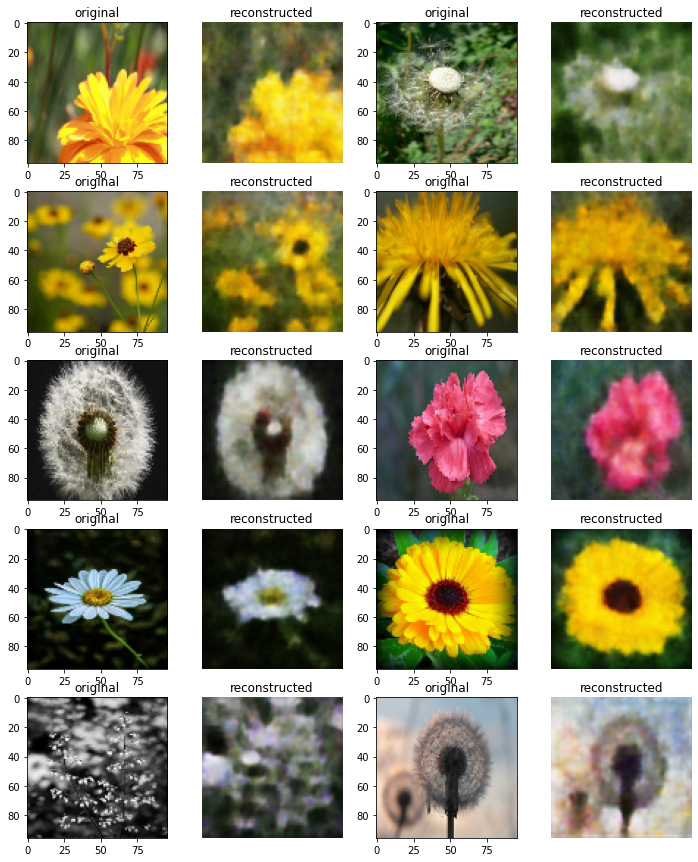

In [ ]:
# visualize a few random flowers
# processed through the ae
plt.figure(figsize=(12, 15))

for images, _ in X_valid.take(1):
  ae_images = ae.predict(images)
  for i in range(10):
    ax = plt.subplot(5, 4, (i * 2) + 1)
    plt.imshow(images[i])
    plt.title('original')

    ax = plt.subplot(5, 4, (i * 2) + 2)
    plt.imshow(ae_images[i])
    plt.title('reconstructed')
    plt.axis("off")

In [14]:
# build a VAE based on AE structure above
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var /2) + mean

inputs = keras.layers.Input(shape = [96, 96, 3])
z = keras.layers.Conv2D(32, input_shape = [96, 96, 3], kernel_size = 3, 
                        padding = 'same', activation = 'relu')(inputs)
z = keras.layers.MaxPool2D()(z)
z = keras.layers.Conv2D(64, kernel_size = 3,
                        padding = 'same', activation = 'relu')(z)
z = keras.layers.MaxPool2D()(z)
z = keras.layers.Conv2D(128, kernel_size = 3,
                        padding = 'same', activation = 'relu')(z)
z = keras.layers.Flatten()(z)
codings_mean = keras.layers.Dense(ENCODING_SIZE)(z)
codings_log_var = keras.layers.Dense(ENCODING_SIZE)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs = [inputs], outputs = [codings_mean, codings_log_var, codings])

variational_encoder.summary()

decoder_inputs = keras.layers.Input(shape = [ENCODING_SIZE])
x = keras.layers.Dense(128 * 24 * 24 , activation = "relu", input_shape = [ENCODING_SIZE * 4])(decoder_inputs)
x = keras.layers.Reshape([24, 24, 128])(x)
x = keras.layers.Conv2DTranspose(filters = 128, kernel_size = 3, strides = 1,
                                 padding = "same", activation = "relu")(x)
x = keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,
                                 padding = "same", activation = "relu")(x)
x = keras.layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2,
                                 padding = "same", activation = "relu")(x)
outputs = keras.layers.Conv2DTranspose(filters = 3, kernel_size = 3, 
                                       padding = 'same', activation = 'sigmoid')(x)
variational_decoder = keras.Model(inputs = [decoder_inputs], outputs = [outputs])

variational_decoder.summary()

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
vae = keras.Model(inputs = [inputs], outputs = [reconstructions])

vae.summary()

# add a loss function
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
                           axis = -1)
vae.add_loss(K.mean(latent_loss) / 27648.)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 96, 96, 32)   896         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 48, 48, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 48, 48, 64)   18496       ['max_pooling2d_2[0][0]']        
                                                                                            

In [15]:
# add learning rate scheduling 
def exponential_decay_fn(epoch):
  return 0.001 * 0.1 ** (epoch / 10)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# add early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

# clear the session for a clean run
keras.backend.clear_session()
tf.random.set_seed(42)

vae.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Nadam())
history = vae.fit(X_train, validation_data = X_valid,  epochs = 50, \
                  callbacks = [lr_scheduler, early_stopping_cb])

Epoch 1/50
322/322 [==============================] - 44s 128ms/step - loss: 0.0525 - val_loss: 0.0387 - lr: 0.0010
Epoch 2/50
322/322 [==============================] - 41s 126ms/step - loss: 0.0357 - val_loss: 0.0371 - lr: 7.9433e-04
Epoch 3/50
322/322 [==============================] - 41s 126ms/step - loss: 0.0316 - val_loss: 0.0304 - lr: 6.3096e-04
Epoch 4/50
322/322 [==============================] - 40s 125ms/step - loss: 0.0295 - val_loss: 0.0311 - lr: 5.0119e-04
Epoch 5/50
322/322 [==============================] - 41s 126ms/step - loss: 0.0284 - val_loss: 0.0285 - lr: 3.9811e-04
Epoch 6/50
322/322 [==============================] - 40s 125ms/step - loss: 0.0277 - val_loss: 0.0287 - lr: 3.1623e-04
Epoch 7/50
322/322 [==============================] - 41s 126ms/step - loss: 0.0272 - val_loss: 0.0275 - lr: 2.5119e-04
Epoch 8/50
322/322 [==============================] - 40s 125ms/step - loss: 0.0268 - val_loss: 0.0275 - lr: 1.9953e-04
Epoch 9/50
322/322 [========================

In [16]:
# save the trained vae
vae.save('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAEwts_1024v2')
variational_encoder.save('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAE_encoder_wts_1024v2')
variational_decoder.save('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAE_decoder_wts_1024v2')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAEwts_1024v2/assets
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAE_encoder_wts_1024v2/assets
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAE_decoder_wts_1024v2/assets


In [ ]:
# load the saved vae
vae = keras.models.load_model('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAEwts')
variational_encoder.load_model('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAE_encoder_wts_1024')
variational_decoder.load_model('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAE_decoder_wts_1024')

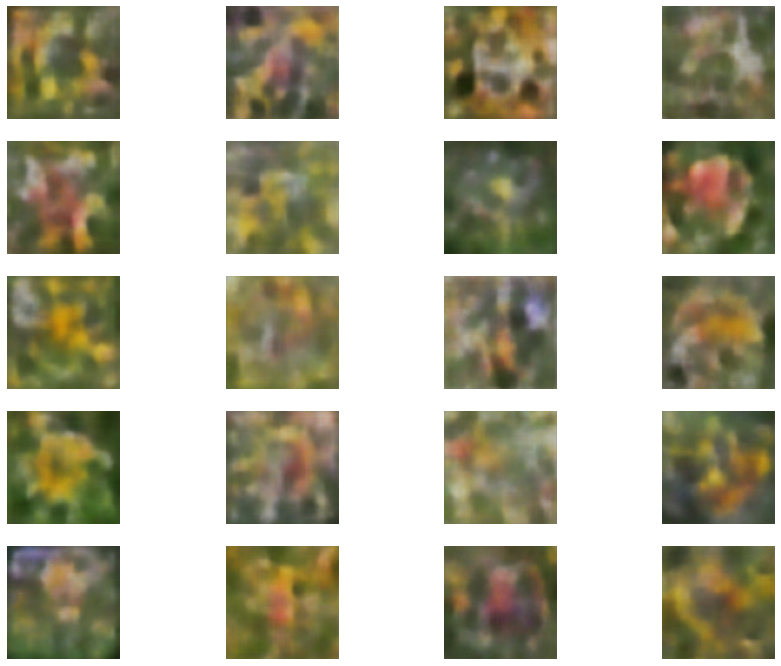

In [17]:
# visualize a few simulated flowers based on random sampling of means
# done with 1024 encoding 
random_codings = tf.random.normal(shape = [20, ENCODING_SIZE])
images = variational_decoder(random_codings).numpy()

plt.figure(figsize=(15, 12))

for i, image in enumerate(images):
  ax = plt.subplot(5, 4, i + 1)
  plt.imshow(image)
  plt.axis("off")

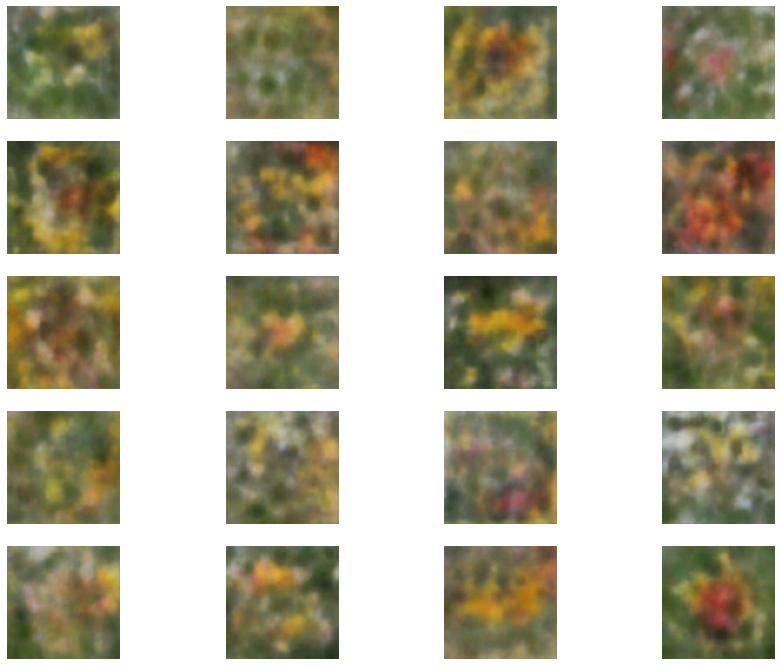

In [ ]:
# visualize a few simulated flowers based on random sampling of means
# done with 2048 encoding
# doesn't improve much on the 1024 that I can see - stick with 1024 
random_codings = tf.random.normal(shape = [20, ENCODING_SIZE])
images = variational_decoder(random_codings).numpy()

plt.figure(figsize=(15, 12))

for i, image in enumerate(images):
  ax = plt.subplot(5, 4, i + 1)
  plt.imshow(image)
  plt.axis("off")

In [18]:
# for each flower type, get the average encoding value
# need a dataset of flowers with labels

flower_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "sample_data/flowers",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = 'inferred'
)

flower_names = flower_generator.class_names

Found 12847 files belonging to 13 classes.


In [29]:
# set up a dictionary to store a few of each flower 
# and list of means to get the effective "average flower" 
# for each flower type
flower_means = {name:{'count':0, 'means':[0 for _ in range(ENCODING_SIZE)]} for name in flower_names}

# hold onto a set of example from each flower type
# *** could store multiple examples and then pull
#     a random one each time the draw code is run
#     so that we don't have to run this code
#     every time we want a new set of examples
flower_examples = {}

# for each flower image, run it through the encoder and extract the means
# get the mean of means for each flower type

for images, labels in flower_generator:
  means, gammas, coding = variational_encoder.predict(images / 255)
  for idx, mean in enumerate(means):
    flower_name = flower_names[labels[idx]]
    flower_means[flower_name]['count'] += 1

    for jdx, element in enumerate(mean):
      flower_means[flower_name]['means'][jdx] += element

    if flower_name not in flower_examples.keys() or random.random() > 0.5:
      flower_examples[flower_name] = images[idx]

for k,v in flower_means.items():
  flower_means[k]['means'] = [m / flower_means[k]['count'] for m in flower_means[k]['means']]


In [30]:
# process mean vectors through decoder to generate
# an image of the "average" flower of each type

for i, (k, v) in enumerate(flower_means.items()):
  flower_means[k]['average_flower']= variational_decoder.predict([v['means']])[0] 

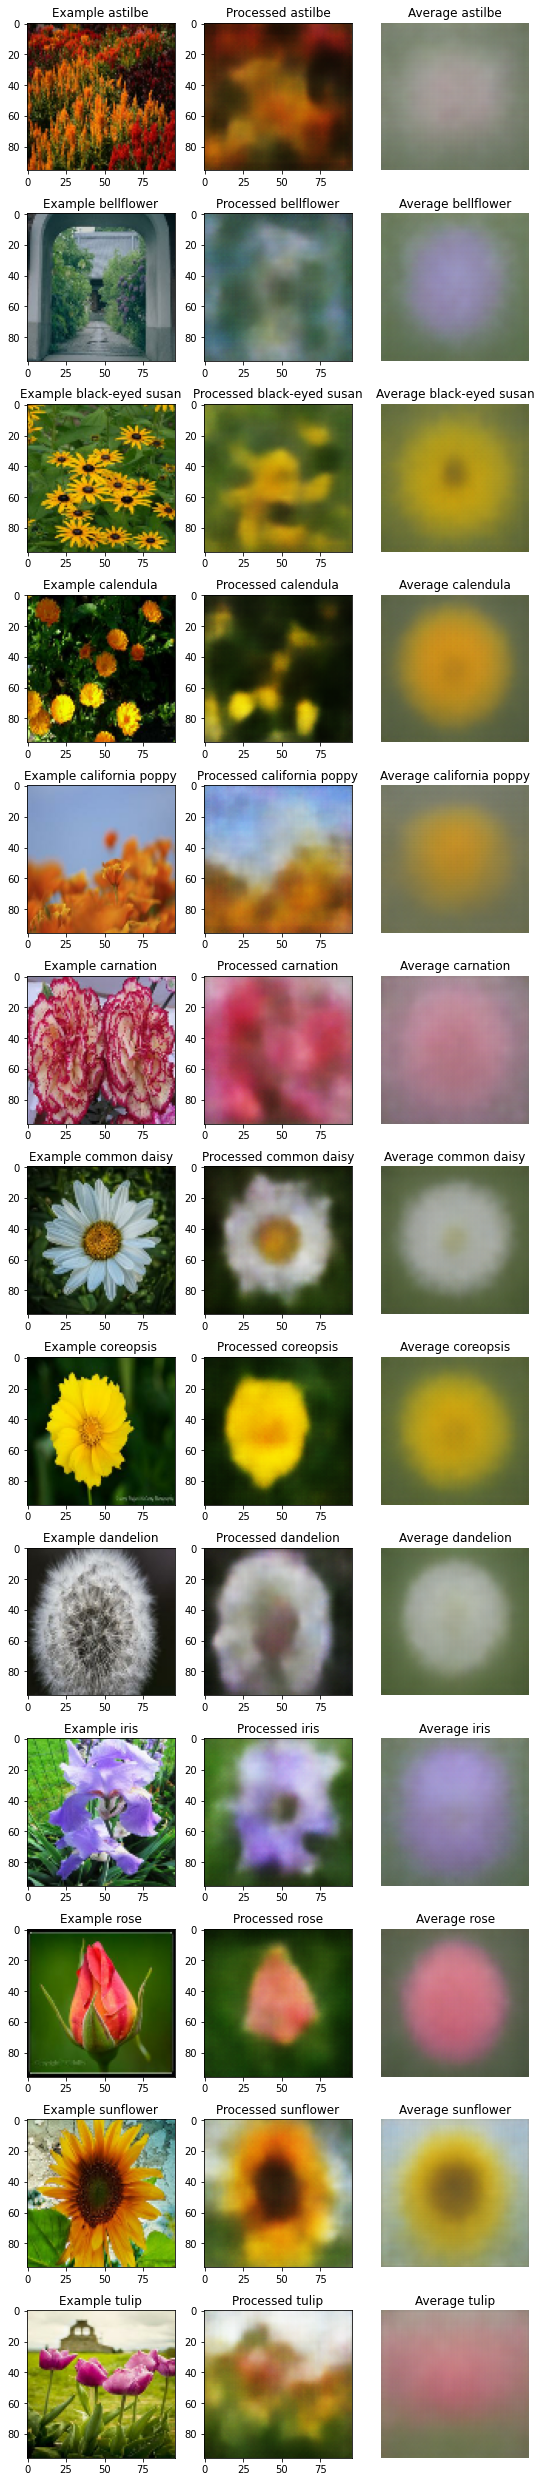

In [31]:
# compare examples, examples run through VAE
# and average flower
plt.figure(figsize=(9, 45))

for i, (k, v) in enumerate(flower_means.items()):
  original_example = flower_examples[k] / 255
  processed_example = vae.predict(original_example[None, ...])
  average_flower = flower_means[k]['average_flower']

  ax = plt.subplot(13, 3, i * 3 + 1)
  plt.imshow(original_example)
  plt.title('Example ' + k)
  ax = plt.subplot(13, 3, i * 3 + 2)
  plt.imshow(processed_example[0])
  plt.title('Processed ' + k)
  ax = plt.subplot(13, 3, i * 3 + 3)
  plt.imshow(average_flower)
  plt.title('Average ' + k)
  plt.axis("off")